<h1>Strategies to prevent overfitting in neural networks</h1>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

try:
    tf.set_random_seed(1337)                    # set the random seed for reproducibility
except:
    tf.random.set_seed(1337)                     # NOTE: Newer version of tensorflow uses tf.random.set_seed
np.random.seed(1337)                         #       instead of tf.set_random_seed

<h2>Introduction</h2>
<p><strong>Business Context.</strong> You are a data scientist working for a machine learning consultancy. One of your clients wants to be able to classify text reviews automatically by the likely rating (on a 1 - 5 scale) that that person would give. However, they do not have sufficient data they generated on their own to do this, so you need to use an external, rich dataset as a basis on which to build your model and then translate it over.</p>
<p><strong>Business Problem.</strong> Your task is to <strong>build a neural networks-based model for classifying text reviews into likely ratings (on a 1 - 5 scale)</strong>.</p>
<p><strong>Analytical Context.</strong> We'll use the Amazon review dataset again and try to classify reviews into star ratings automatically. Instead of just positive and negative, we'll take on the harder challenge of predicting the <em>exact</em> star rating. The lowest score is 1 and the highest is 5.</p>
<p>Instead of trying to optimize by pre-processing the text, we'll do very basic tokenization and experiment with different neural network models, architectures, and hyperparameters to optimize the results. You'll start by building a simple dense neural network and try to get it to perform better using various techniques. Then you'll evaluate the results and diagnose where it tends to perform more poorly.</p>

<h2>Setting up and preparing the data</h2>
<p>We'll mainly be using the <code>keras</code> module from TensorFlow, but we'll also use <code>pandas</code> to read the CSV file and <code>sklearn</code> for some helper functions. We'll be using only the "Text" and "Score" columns in the <code>Reviews.csv</code> file:</p>

In [2]:
amazon_reviews = pd.read_csv('Reviews.csv', nrows=262084)
amazon_reviews.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<h3>Exercise 1:</h3>
<p>Combine the first 1,000 of each of the 1-, 2-, 3-, 4-, and 5-star reviews in <code>amazon_reviews</code> into a single DataFrame (so you should have 5,000 observations in total). Split this DataFrame into training and test sets, with 80% of the data for the training set.</p>
<p><strong>Hint:</strong> <code>keras</code> will expected your labels to start with 0, and not 1, so make sure to adjust the labels accordingly.</p>

**Answer.**

In [3]:
#Generamos el nuestro nuevo conjunto de datos, el cual contiene las primeras 1000 revisiones para cada Score
# Para lo cual definimos una funcion donde las entradas son el dataframe y un numero que indica la cantidad de categorias
def select_review(dataframe,n,row):
    score = list(range(1,n+1))
    review = []
    for i in score:
        df_score = f'df_score{i}'
        df_score = dataframe[dataframe['Score'] == i][['Text','Score']][0:row]
        review.append(df_score)
        df_review = pd.concat(review).reset_index(drop=True)
    
    return df_review

#Adicionalmente definimos una funcion que permita iniciar las categorias desde 0, tal como las requiere keras

def cat_keras(score):
    if score == 1:
        return 0
    elif score == 2:
        return 1
    elif score == 3:
        return 2
    elif score == 4:
        return 3
    else: 
        return 4

In [4]:
# El nuevo dataset solo cuenta con la columna Text y la Columna Score que se ha transformado para que sea aceptado por Keras
data_review = select_review(amazon_reviews,5,1000)
data_review['Score'] = data_review.Score.apply(cat_keras)
data_review

,Text,Score
0,Product arrived labeled as Jumbo Salted Peanut...,0
1,My cats have been happily eating Felidae Plati...,0
2,"The candy is just red , No flavor . Just plan...",0
3,"This oatmeal is not good. Its mushy, soft, I d...",0
4,Arrived in 6 days and were so stale i could no...,0
...,...,...
4995,i followed the easy instructions and these tur...,4
4996,WE LOVE LOVE LOVE these muffins. They are mois...,4
4997,I brought 2 bottles. One I carry in my pocket...,4
4998,I really like this soup. It is mild and I don...,4


In [5]:
# Dividir datos de entrenamiento 80% y test 20%
y = data_review['Score']
X = data_review['Text']

# Definimos una semilla con el fin de poder replicar la muestra y el tamaño del conjunto de test

random = 12345
test = 0.2

# randomize train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test, random_state=random)

In [6]:
# Validamos los tamaños de los conjuntos de entrenamiento y test
print('Review para entrenamiento: ',X_train.shape[0])
print('Target para entrenamiento: ',y_train.shape[0])
print('Review para test: ',X_test.shape[0])
print('Target para test: ',y_test.shape[0])

Review para entrenamiento:  4000
Target para entrenamiento:  4000
Review para test:  1000
Target para test:  1000


In [7]:
#A continuacion validamos la distribucion de las categorias se observa que la distribucion de review
# por cada categoria es uniforme en el conjunto de entrenamiento y por lo tanto tambien en test.

y_train.value_counts()

4    809
0    808
1    807
3    790
2    786
Name: Score, dtype: int64

<h2>Tokenizing our texts</h2>
<p>Keras comes with its own functions to preprocess text, including a <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">tokenizer</a> (a mapping from each word in our corpus to a unique integer). Unlike the <code>CountVectorizer</code> from <code>sklearn</code>, which produces sparse matrices, <code>keras</code> often expects to work with sequences representing only the words that occur in a text. To prepare text before feeding it into a neural network, we usually:</p>
<ol>
<li>Create a <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">tokenizer</a>.</li>
<li><a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences">Create sequences</a> from our text (each text becomes a list of integers, based on the tokenizer mapping, instead of words)</li>
<li><a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences">Pad or truncate</a> each sequence to a fixed length (very short texts get <code>0</code>s added to them, while very long ones are truncated).</li>
</ol>
<p>The tokenizer has a configurable word cap, so it will only consider the $n$ most common words in the corpus, ignoring very rare words.</p>

<h3>Exercise 2:</h3>
<p>In this exercise, you will learn how to use the <code>tf.keras.preprocessing.text.Tokenizer</code> tool to carry out the preprocessing steps described above.</p>
<h4>2.1</h4>
<p>Perform some exploratory analysis of the dataset to calculate the number of unique words in our corpus and the distribution of the number of words in each review of the training set. What is the 80th percentile of this distribution?</p>

**Answer.**

In [8]:
#Determinamos el numero de palabras promedio en cada review
words_x_review = X_train.apply(lambda x: len(x.split(" ")))
print('Cada review contiene',  words_x_review.mean(),  'palabras en promedio')
percentil = np.percentile(words_x_review,80)
print('El 80th percentil de las revisiones es: ', percentil)

Cada review contiene 86.76475 palabras en promedio
El 80th percentil de las revisiones es:  121.0


In [9]:
#Se importa de nltk la libreria que contiene la lista de stopwords

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re, string # para extraer los signos de puntuacion

# defino una funcion para reemplazar los signos de puntuación y filtrar las palabras de parada

def filter_stopwords(text):
    without_stopwords = []
    stop_words = set(stopwords.words("english"))
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    words = nltk.word_tokenize(text)
    for word in words:
        if word in stop_words:
            pass
        else: 
            without_stopwords.append(word)
    return without_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guerr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Para determinar el numero de palabra unicas en el set de datos de entrenamiento, se unen todos los review en un solo Corpus.
words_all = ' '.join(X_train)
words_uniques_X_train = filter_stopwords(words_all)
corpus = set(words_uniques_X_train)
size_corpus = len(corpus)
print ('La cantidad de palabras unicas en el Corpus son: ',size_corpus)

# Luego de aplicar nuestra funcion para tokenizar y remover del Corpus los signos de puntuacion se observa
# que el corpus con nuestra tokenizacion y limpieza de signos de puntuacion tiene 16235 palabras unicas

La cantidad de palabras unicas en el Corpus son:  16235


<h4>2.2</h4>
<p>Given the results above, we create a tokenizer using only the top 20,000 most frequent words in our corpus (which corresponds to roughly 80% of the words): </p>

In [11]:
tokenizer = Tokenizer(num_words=20000) #We create the tokenizer using only top 20000 words

In [12]:
tokenizer.fit_on_texts(X_train)  #Then, we create the text->indices mapping. 

The above line has given several features and methods to our tokenizer. For instance, print the line `tokenizer.word_index` in a new cell - what do you see? Apply the `tokenizer.texts_to_sequences()` method on the list `['I just feel very very good']`. Apply the `tokenizer.sequences_to_texts()` method on the list `[[109, 19, 824, 76, 114, 6315, 1137, 8070]]`. What were your results?

**Answer.**

In [13]:
# Al utilizar tokenizer.word_index se observa el valores que el tokenizador asigno a cada palabra unica en el corpus
# En este punto es importante resalta que el tokenizador de keras reduce el corpus de entrenamiento un 17% mas que la tokenizacion
# realizad con nuestra funcion trabajando con 13572 palabras unicas.
corpus_keras = tokenizer.word_index
print('Tamaño del Corpus_keras',len(corpus_keras),'palabras unicas')
print()
print(corpus_keras)

Tamaño del Corpus_keras 13572 palabras unicas

{'the': 1, 'i': 2, 'a': 3, 'and': 4, 'to': 5, 'it': 6, 'of': 7, 'br': 8, 'is': 9, 'this': 10, 'in': 11, 'for': 12, 'that': 13, 'but': 14, 'not': 15, 'my': 16, 'was': 17, 'with': 18, 'have': 19, 'you': 20, 'are': 21, 'as': 22, 'they': 23, 'like': 24, 'on': 25, 'so': 26, 'these': 27, 'be': 28, 'taste': 29, 'good': 30, 'if': 31, 'them': 32, 'product': 33, 'coffee': 34, 'or': 35, 'just': 36, 'at': 37, 'all': 38, 'very': 39, 'one': 40, 'would': 41, 'flavor': 42, "it's": 43, 'had': 44, 'can': 45, 'from': 46, 'more': 47, 'me': 48, 'when': 49, 'will': 50, 'than': 51, 'out': 52, 'no': 53, 'has': 54, 'other': 55, 'we': 56, 'were': 57, 'great': 58, 'much': 59, 'some': 60, "don't": 61, 'really': 62, 'too': 63, 'up': 64, 'because': 65, 'there': 66, 'only': 67, 'about': 68, 'get': 69, 'chips': 70, 'an': 71, 'food': 72, 'tea': 73, 'your': 74, 'what': 75, 'amazon': 76, 'which': 77, 'little': 78, 'buy': 79, 'better': 80, 'sugar': 81, 'also': 82, 'even': 83

In [14]:
#la funcion "tokenizer.texts_to_sequences" devuelve el valor asignado a cada palabra dentro del Corpus 
tokenizer.texts_to_sequences(['I just feel very very good'])

[[2, 36, 351, 39, 39, 30]]

In [15]:
#la funcion "tokenizer.sequences_to_texts" devuelve los valores de las palabras en el Corpus de acuerdo al valor que se asigno
tokenizer.sequences_to_texts([[109, 19, 824, 76, 114, 6315, 1137, 8070]])

['2 have night amazon did caking sampler locking']

<h4>2.3</h4>
<p>Use the tokenizer to transform the texts in our test and train data to sequences. Then, use the <code>pad_sequences</code> function to pad/truncate these sequences to length 116 (the 80th percentile of text lengths). Save the resulting arrays as <code>train_sequences</code> and <code>test_sequences</code>.</p>

**Answer.**

In [16]:
# Entonces las secuencias (review convertidos en array), para nuestros datos de entrenamiento son:
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences[0])

[10, 54, 5, 28, 189, 3, 1141, 1, 703, 326, 132, 121, 238, 1, 113, 126, 5, 1384, 1, 29, 7, 10, 222, 9, 62, 492, 4744, 137, 713, 132, 121, 1078, 838, 713, 9, 126, 80, 4, 431, 162, 98, 67, 117, 155, 957, 1, 611, 11, 1, 1385, 347, 6, 7731, 4, 3016, 16, 821, 4, 419, 12, 10, 3327]


In [17]:
# pad_sequences permite que unificar el tamaño de los review en este caso a 116 valores, si el review tiene menos
# de 116 palabras, los valores faltantes se rellenaran con ceros
padded_train_sequences = pad_sequences(train_sequences, maxlen=116, padding='post', truncating='post')
print('Tamaño del array de cada review: ',len(padded_train_sequences[0]))
print()
print(padded_train_sequences[0])

Tamaño del array de cada review:  116

[  10   54    5   28  189    3 1141    1  703  326  132  121  238    1
  113  126    5 1384    1   29    7   10  222    9   62  492 4744  137
  713  132  121 1078  838  713    9  126   80    4  431  162   98   67
  117  155  957    1  611   11    1 1385  347    6 7731    4 3016   16
  821    4  419   12   10 3327    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [18]:
# Ahora realizamos la preparacion de los datos de test X_test
tokenizer.fit_on_texts(X_test)
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences, maxlen=116, padding='post', truncating='post')
print('Tamaño del array de cada review: ',len(padded_test_sequences[0]))
print()
print(padded_test_sequences[0])

Tamaño del array de cada review:  116

[  57  101  192   10   34   11    1 3492   34  735   11 2437 2712  206
   25 2399   57  122    3  191  176    4 1392   33  213  440   18  359
 2437 2712 6095 4083   34  380  987   57  269   30   34    4    6    9
  115   11    1  517   43  199  740  294 1437    4   15  348   11  147
  290   92 1727   34  949   57   86  142 4407 6357   67  157 6345   48
   57 1594    1  340    7    1   34   57  578   25   71    4  125    1
 1632  143   57   44  261   11 2437 2712   57  122  699  176    4   51
   28  378   47    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


<h2>Building a basic neural network model</h2>
<p>Now that we have preprocessed the text, let's create a basic neural network to train on our data. We'll use an embedding layer which performs <a href="https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/">one-hot encoding</a> on our word sequences, two fully connected ("dense") layers, and an output layer with 5 neurons to represent the 5 possible star ratings.</p>
<p>Before we train a <code>keras</code> model, there is an additional <code>compile</code> step where we define what loss function and optimizer to use, and what metrics to output. Then we can train the model using the <code>fit</code> function. All of this is shown below.</p>
<p>Note the <code>validation_split=0.2</code> argument which tells Keras to train on only 80% of the training data and tune the model on the remaining 20%, which we call the validation set. You can see the accuracy and loss for both the training and validation set in the output for each epoch:</p>

In [19]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 128)          2560000   
_________________________________________________________________
dense (Dense)                (None, 116, 128)          16512     
_________________________________________________________________
dense_1 (Dense)              (None, 116, 128)          16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 2,593,669
Trainable params: 2,593,669
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(padded_train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 10s 3ms/sample - loss: 1.5885 - accuracy: 0.2519 - val_loss: 1.5340 - val_accuracy: 0.3775
Epoch 2/10
3200/3200 [==============================] - 8s 3ms/sample - loss: 1.3748 - accuracy: 0.4281 - val_loss: 1.3965 - val_accuracy: 0.4050
Epoch 3/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 1.0613 - accuracy: 0.5719 - val_loss: 1.2903 - val_accuracy: 0.4675
Epoch 4/10
3200/3200 [==============================] - 8s 3ms/sample - loss: 0.7393 - accuracy: 0.7350 - val_loss: 1.3734 - val_accuracy: 0.4512
Epoch 5/10
3200/3200 [==============================] - 8s 3ms/sample - loss: 0.4608 - accuracy: 0.8616 - val_loss: 1.5195 - val_accuracy: 0.4638
Epoch 6/10
3200/3200 [==============================] - 8s 3ms/sample - loss: 0.2429 - accuracy: 0.9472 - val_loss: 1.6715 - val_accuracy: 0.4563
Epoch 7/10
3200/3200 [==============================] - 8s 3ms/sample - loss

<h3>Exercise 3:</h3>
<p>How well does this model perform? How does this compare to a baseline expectation? What do you notice about the accuracy and loss values for both the validation and training sets over time and what does this mean?</p>

**Answer.**

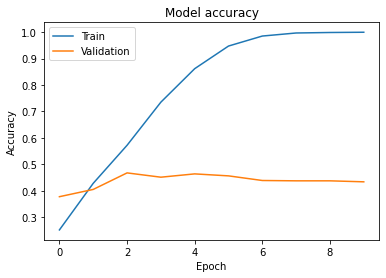

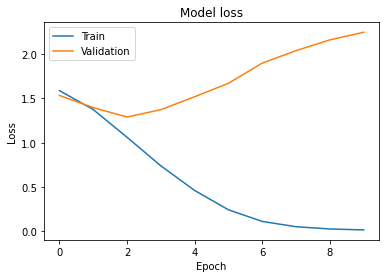

In [22]:
# Para ver como se comporta el modelo vamos a graficar los valores de accuracy y loss
# en los conjuntos de entrenamiento y validacion.

import matplotlib.pyplot as plt
%matplotlib inline
# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

***Se observa que el modelo tiene una excelente respuesta para los datos de test, alcanzando el 100% de accuracy al predecir las clases pero en los datos de validacion no se logra que supere el 45%, cual indica que el modelo se encuentra sobreajustado, lo cual se evidencia en la grafica de loss ya que para los datos de validacion aumentan despues de la segunda epoca mientras que en los datos de entrenamiento disminuyen***

<h2>Experimenting with different regularization strategies</h2>
<p>There are many different ways to mitigate overfitting in a neural network, collectively known as <em>regularization</em> techniques. One common regularization technique is called <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout">Dropout</a>. In this regularization method, a set of neurons is randomly selected at each training step to be completely ignored. This is done so that the neurons in our network do not rely strongly on their neighboring neurons and we avoid the creation of <a href="http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf">"co-adaptations"</a> that do not generalize well to unseen data. This making the model more robust and less prone to overffiting.</p>
<p>You can create dropouts in <code>keras</code> by adding a layer named <code>Dropout(p)</code>, where <code>p</code> is the probability of dropping neurons in the previous layer. For example, the following model would implement dropout by removing roughly 20% percent of the outputs of the embedding layer at each training step:</p>

In [23]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dense(128, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit(padded_train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.5928 - accuracy: 0.2478 - val_loss: 1.5493 - val_accuracy: 0.3388
Epoch 2/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 1.4372 - accuracy: 0.3881 - val_loss: 1.4418 - val_accuracy: 0.4050
Epoch 3/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 1.1977 - accuracy: 0.5028 - val_loss: 1.3150 - val_accuracy: 0.4487
Epoch 4/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 0.9408 - accuracy: 0.6356 - val_loss: 1.3528 - val_accuracy: 0.4512
Epoch 5/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 0.7005 - accuracy: 0.7472 - val_loss: 1.4475 - val_accuracy: 0.4588
Epoch 6/10
3200/3200 [==============================] - 9s 3ms/sample - loss: 0.4701 - accuracy: 0.8478 - val_loss: 1.6001 - val_accuracy: 0.4588
Epoch 7/10
3200/3200 [==============================] - 9s 3ms/sample - loss

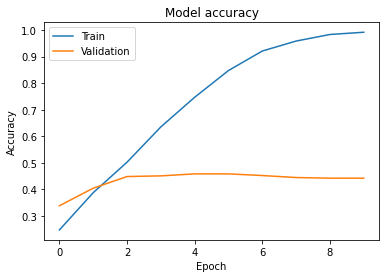

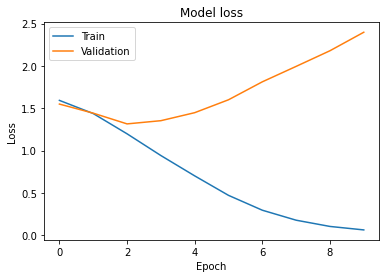

In [24]:
# Plot training and validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<h3>Exercise 4:</h3>
<p>Modify the neural network definition above to try and fix the overfitting problem using Dropout. Explain the configuration that you tried and your results. Why do you think your modifications were or were not able to mitigate the overfitting problem?</p>

**Answer.**

In [25]:
model3 = Sequential()
model3.add(Embedding(20000, 128, input_length=116))
model3.add(Dropout(0.3))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(5, activation='sigmoid'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history3 = model3.fit(padded_train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 13s 4ms/sample - loss: 1.5974 - accuracy: 0.2297 - val_loss: 1.5775 - val_accuracy: 0.2900
Epoch 2/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.5228 - accuracy: 0.3125 - val_loss: 1.5245 - val_accuracy: 0.3137
Epoch 3/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.3823 - accuracy: 0.3878 - val_loss: 1.4155 - val_accuracy: 0.3812
Epoch 4/10
3200/3200 [==============================] - 10s 3ms/sample - loss: 1.2403 - accuracy: 0.4631 - val_loss: 1.3671 - val_accuracy: 0.4263
Epoch 5/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.1007 - accuracy: 0.5469 - val_loss: 1.3366 - val_accuracy: 0.4400
Epoch 6/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.9313 - accuracy: 0.6338 - val_loss: 1.3539 - val_accuracy: 0.4437
Epoch 7/10
3200/3200 [==============================] - 11s 3ms/sample 

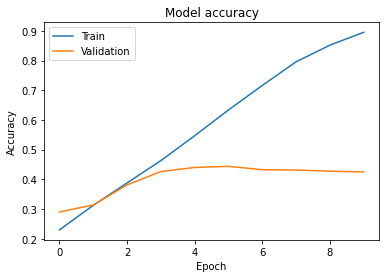

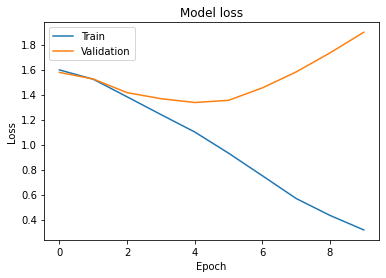

In [26]:
# Plot training and validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

***Aplicar Dropout no mejora significativamente el accuracy en los datos de validacion, pero el aumentar la probabilidad de que una neurona sea ignorada en su capa disminuye tambien los valores de accuracy en los datos de test.
Conclusion si bien el Dropuot permite disminuir el sobreajuste en este modelo no es significativo.***

<h3>Exercise 5:</h3>
<p>Keras allows you to add <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1">L1</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2">L2</a>, or <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1_l2">L1 and L2</a> combined regularizers on individual layers by passing in the <code>kernel_regularizer</code>, <code>bias_regularizer</code> or <code>activity_regularizer</code> arguments. In neural networks, these regularizers work by penalizing the loss function in different ways, based on the number of weights or the size of the weights.</p>
<p>Try 4-5 different combinations of L1, L2, L1 and L2 regularization in different combinations on different layers. In each example, explain why you tried that configuration and the results. Why do you think your modifications were or were not able to mitigate the overfitting problem?</p>

**Answer.**

#### Ajuste a traves de la penalizacion de la funcion de perdida
***L2: la suma de los valores al cuadrado de los pesos  
L1: la suma de los valores absolutos de los pesos***

In [32]:
# Castigar la funcion de perdida de los valores absolutos de los pesos no le ayuda a la funcion a generalizar las
# caracteristicas del modelo por el contrario las perdidas en el conjunto de validacion aumentan.

from tensorflow.keras.regularizers import l1
l1 = tf.keras.regularizers.l1(0.005)
model4 = Sequential()
model4.add(Embedding(20000, 128, input_length=116))
model4.add(Dropout(0.3))
model4.add(Dense(128, activation='relu',kernel_regularizer='l1'))
model4.add(Dropout(0.2))
model4.add(Dense(128, activation='relu',kernel_regularizer='l1'))
model4.add(Dropout(0.2))
model4.add(GlobalMaxPooling1D())
model4.add(Dense(5, activation='sigmoid'))
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history4 = model4.fit(padded_train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.2110 - accuracy: 0.9322 - val_loss: 2.0382 - val_accuracy: 0.4238
Epoch 2/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.1659 - accuracy: 0.9506 - val_loss: 2.3053 - val_accuracy: 0.4075
Epoch 3/10
3200/3200 [==============================] - 10s 3ms/sample - loss: 0.1238 - accuracy: 0.9613 - val_loss: 2.4442 - val_accuracy: 0.3988
Epoch 4/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 0.0959 - accuracy: 0.9706 - val_loss: 2.5698 - val_accuracy: 0.4112
Epoch 5/10
3200/3200 [==============================] - 11s 4ms/sample - loss: 0.0704 - accuracy: 0.9831 - val_loss: 2.6687 - val_accuracy: 0.4013
Epoch 6/10
3200/3200 [==============================] - 10s 3ms/sample - loss: 0.0595 - accuracy: 0.9822 - val_loss: 2.7649 - val_accuracy: 0.4100
Epoch 7/10
3200/3200 [==============================] - 10s 3ms/sample 

In [33]:
# Aumentar la velocidad con la que el modelo aprende y aplicar la regularizacion afecto negativamente el rendimeinto del modelo
from tensorflow.keras.regularizers import l1
l1 = tf.keras.regularizers.l1(0.01)
model5 = Sequential()
model5.add(Embedding(20000, 128, input_length=116))
model5.add(Dropout(0.3))
model5.add(Dense(128, activation='relu',kernel_regularizer='l1'))
model5.add(Dropout(0.2))
model5.add(Dense(128, activation='relu',kernel_regularizer='l1'))
model5.add(Dropout(0.2))
model5.add(GlobalMaxPooling1D())
model5.add(Dense(5, activation='sigmoid'))
model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history5 = model5.fit(padded_train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 13s 4ms/sample - loss: 14.1224 - accuracy: 0.1994 - val_loss: 4.7586 - val_accuracy: 0.1887
Epoch 2/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 2.2584 - accuracy: 0.2034 - val_loss: 1.6530 - val_accuracy: 0.1887
Epoch 3/10
3200/3200 [==============================] - 12s 4ms/sample - loss: 1.6504 - accuracy: 0.2053 - val_loss: 1.6519 - val_accuracy: 0.1887
Epoch 4/10
3200/3200 [==============================] - 13s 4ms/sample - loss: 1.6499 - accuracy: 0.2053 - val_loss: 1.6512 - val_accuracy: 0.1887
Epoch 5/10
3200/3200 [==============================] - 13s 4ms/sample - loss: 1.6498 - accuracy: 0.2053 - val_loss: 1.6515 - val_accuracy: 0.1887
Epoch 6/10
3200/3200 [==============================] - 13s 4ms/sample - loss: 1.6499 - accuracy: 0.2053 - val_loss: 1.6518 - val_accuracy: 0.1887
Epoch 7/10
3200/3200 [==============================] - 12s 4ms/sample

In [35]:
# En este modelo no solo se van afectar los pesos, sino tambien los sesgos con la funcion bias_regularizer
# Observamos que la regularizacion l2 tampoco impacta sobre los resultados obtenidos a pesar de que disminuye el sobreajuste.
from tensorflow.keras.regularizers import l2
l2 = tf.keras.regularizers.l2(0.005)
model7 = Sequential()
model7.add(Embedding(20000, 128, input_length=116))
model7.add(Dropout(0.3))
model7.add(Dense(128, activation='relu',kernel_regularizer='l2',bias_regularizer ='l2' ))
model7.add(Dropout(0.2))
model7.add(Dense(128, activation='relu',kernel_regularizer='l2',bias_regularizer ='l2' ))
model7.add(Dropout(0.2))
model7.add(GlobalMaxPooling1D())
model7.add(Dense(5, activation='sigmoid'))
model7.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history7 = model7.fit(padded_train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 13s 4ms/sample - loss: 2.6873 - accuracy: 0.2078 - val_loss: 1.8694 - val_accuracy: 0.3038
Epoch 2/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6988 - accuracy: 0.2066 - val_loss: 1.6236 - val_accuracy: 0.1887
Epoch 3/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6134 - accuracy: 0.2053 - val_loss: 1.6109 - val_accuracy: 0.1887
Epoch 4/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6094 - accuracy: 0.2006 - val_loss: 1.6105 - val_accuracy: 0.1887
Epoch 5/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6093 - accuracy: 0.2053 - val_loss: 1.6107 - val_accuracy: 0.1887
Epoch 6/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6093 - accuracy: 0.2003 - val_loss: 1.6107 - val_accuracy: 0.1887
Epoch 7/10
3200/3200 [==============================] - 11s 4ms/sample 

In [47]:
# Combinar los regularizadores L1 y L2 tampoco tiene un efecto positivo en el modelo, por el contrario
# se registran los valores masde accuracy en los datos de entrenamiento y validacion.
from tensorflow.keras.regularizers import L1L2
l1_l2 = tf.keras.regularizers.L1L2( l1 = 0.005, l2 = 0.005)
model7 = Sequential()
model7.add(Embedding(20000, 128, input_length=116))
model7.add(Dropout(0.3))
model7.add(Dense(128, activation='relu',kernel_regularizer='l1_l2'))
model7.add(Dropout(0.2))
model7.add(Dense(128, activation='relu',kernel_regularizer='l1_l2'))
model7.add(Dropout(0.2))
model7.add(GlobalMaxPooling1D())
model7.add(Dense(5, activation='sigmoid'))
model7.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history7 = model7.fit(padded_train_sequences, y_train, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 13s 4ms/sample - loss: 15.1958 - accuracy: 0.1953 - val_loss: 5.1843 - val_accuracy: 0.1887
Epoch 2/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 2.4117 - accuracy: 0.2053 - val_loss: 1.6541 - val_accuracy: 0.1887
Epoch 3/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6506 - accuracy: 0.2053 - val_loss: 1.6514 - val_accuracy: 0.1887
Epoch 4/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6499 - accuracy: 0.2053 - val_loss: 1.6515 - val_accuracy: 0.1887
Epoch 5/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6498 - accuracy: 0.2053 - val_loss: 1.6511 - val_accuracy: 0.1887
Epoch 6/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6497 - accuracy: 0.2053 - val_loss: 1.6510 - val_accuracy: 0.1887
Epoch 7/10
3200/3200 [==============================] - 11s 4ms/sample

<h2>Regularization through adding more data</h2>
<p>Depending on the configurations you tried above, you probably saw that L1 and L2 regularization are pretty limited for this model and this amount of data. A more straightforward way to prevent overfitting is simply by adding more training data. If the network has more (and more varied) examples to learn from, perhaps it will learn more generalizable rules.</p>

<h3>Exercise 6:</h3>
<p>How would you test the hypothesis that adding more data would result in a more generalizable model? Explain any change in results you see from further experimentation.</p>
<p><strong>Hint:</strong> Try adding 6000 reviews for each score instead. Compare with the original proposed model.</p>

**Answer.**

In [48]:
# El nuevo dataset tendra 6000 de cada categoria con la columna Text y
# la Columna Score que se ha transformado para que sea aceptado por Keras
# Para procesar el set de datos utilizamos las funciones "select_review" y "cat_keras" que definimos al inicio del caso.
data2_review = select_review(amazon_reviews,5,6000)
data2_review['Score'] = data2_review.Score.apply(cat_keras)
data2_review

,Text,Score
0,Product arrived labeled as Jumbo Salted Peanut...,0
1,My cats have been happily eating Felidae Plati...,0
2,"The candy is just red , No flavor . Just plan...",0
3,"This oatmeal is not good. Its mushy, soft, I d...",0
4,Arrived in 6 days and were so stale i could no...,0
...,...,...
29995,"They weren't mind-blowing, but they were defin...",4
29996,This is my first time with the miracle berries...,4
29997,"It works. i took one, 2 minutes later i was tr...",4
29998,"This stuff really works, makes lemons taste sw...",4


In [49]:
# Ahora nuestro dataset tiene 30000 review, las cuales seran procesadas como el cojunto de datos anterior 
# 80% de datos de entrenamiento y 20% para test

y2 = data2_review['Score']
X2 = data2_review['Text']

# Definimos una semilla con el fin de poder replicar la muestra y el tamaño del conjunto de test

random = 12345
test = 0.2

# randomize train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size= test, random_state=random)

In [50]:
# Para el preprocesamiento utilizaremos las mismas caracteristicas, aplicadas al conjunto de datos de 5000 review
tokenizer = Tokenizer(num_words=20000) #Se realizara el tokenizado y solo se tendran en cuenta 20000 palabras mas usadas
tokenizer.fit_on_texts(X2_train)
corpus_keras2 = tokenizer.word_index
print('Tamaño del Corpus_keras',len(corpus_keras2),'palabras unicas')
print()
print(corpus_keras2)

Tamaño del Corpus_keras 31839 palabras unicas

{'the': 1, 'i': 2, 'a': 3, 'and': 4, 'to': 5, 'it': 6, 'of': 7, 'br': 8, 'is': 9, 'this': 10, 'in': 11, 'for': 12, 'that': 13, 'but': 14, 'not': 15, 'my': 16, 'was': 17, 'with': 18, 'have': 19, 'you': 20, 'are': 21, 'they': 22, 'like': 23, 'as': 24, 'on': 25, 'so': 26, 'these': 27, 'be': 28, 'taste': 29, 'them': 30, 'good': 31, 'if': 32, 'product': 33, 'just': 34, 'or': 35, 'at': 36, 'one': 37, 'coffee': 38, 'very': 39, 'flavor': 40, 'all': 41, 'would': 42, 'from': 43, 'had': 44, "it's": 45, 'more': 46, 'me': 47, 'can': 48, 'when': 49, 'out': 50, 'will': 51, 'has': 52, 'than': 53, 'no': 54, 'tea': 55, 'other': 56, 'great': 57, 'we': 58, 'food': 59, 'really': 60, 'get': 61, "don't": 62, 'some': 63, 'were': 64, 'up': 65, 'much': 66, 'about': 67, 'too': 68, 'only': 69, 'because': 70, 'there': 71, 'an': 72, 'what': 73, 'amazon': 74, 'your': 75, 'do': 76, 'love': 77, 'which': 78, 'little': 79, 'buy': 80, 'time': 81, 'also': 82, 'even': 83, 'bet

In [52]:
# Las secuencias (review convertidos en array), para nuestros datos de entrenamiento son:
train_sequences2 = tokenizer.texts_to_sequences(X2_train)
print(train_sequences2[0])

[16, 473, 77, 2427, 14, 2, 123, 54, 492, 88, 1, 216, 329, 11, 1, 399, 164, 18, 3, 31, 3069, 2, 120, 366, 1, 1013, 7, 3, 157, 169, 27, 1002, 1, 1937, 22, 93, 81, 2, 110, 30, 22, 150, 22, 199, 1399, 70, 22, 64, 26, 125, 5, 1, 1147, 2094, 114, 22, 103, 30, 65, 4, 19, 1169, 125, 5, 1, 2484, 29, 2, 118, 22, 21, 940, 8, 27, 21, 11, 54, 124, 257, 624, 35, 257, 274, 169, 903, 846, 12, 3, 176, 7, 264, 1180, 4, 359, 20, 48, 89, 1626, 1176, 4, 1051, 8126, 32, 344, 1528, 2484, 665, 82, 19, 3, 31, 323, 7, 274, 410, 1, 246, 308, 102, 110, 30, 18, 944, 264, 148, 4, 22, 64, 34, 24, 31, 102, 82, 306, 436, 204, 487, 427, 5, 97, 30, 436, 2703, 14, 22, 60, 62, 250, 6, 2, 77, 1, 816, 228, 7, 1, 2484, 665, 71, 21, 39, 170, 152, 2, 123, 242, 97, 1, 145, 2427, 1277, 14, 6, 42, 28, 3, 1612, 5, 19, 5, 1102, 1, 2484, 665, 502, 27, 21, 278, 4, 940, 83, 169, 22, 21, 15, 2296, 246, 43, 3, 624, 4, 274, 5494, 2, 48, 303, 31, 67, 521, 16, 473, 166, 13, 615, 1767, 18, 1147, 2094]


In [53]:
# pad_sequences permite que unificar el tamaño de los review en este caso a 116 valores, si el review tiene mas
# de 116 palabras, los valores la sequencia se trunca a 116, como observamos a continuacion.
padded_train_sequences2 = pad_sequences(train_sequences2, maxlen=116, padding='post', truncating='post')
print('Tamaño del array de cada review: ',len(padded_train_sequences2[0]))
print()
print(padded_train_sequences2[0])

Tamaño del array de cada review:  116

[  16  473   77 2427   14    2  123   54  492   88    1  216  329   11
    1  399  164   18    3   31 3069    2  120  366    1 1013    7    3
  157  169   27 1002    1 1937   22   93   81    2  110   30   22  150
   22  199 1399   70   22   64   26  125    5    1 1147 2094  114   22
  103   30   65    4   19 1169  125    5    1 2484   29    2  118   22
   21  940    8   27   21   11   54  124  257  624   35  257  274  169
  903  846   12    3  176    7  264 1180    4  359   20   48   89 1626
 1176    4 1051 8126   32  344 1528 2484  665   82   19    3   31  323
    7  274  410    1]


In [54]:
# Entrenamos con nuestro primer modelo a quien solo cambiaremos el nombre para poder almacenar  y mostrar sus resultados
model6 = Sequential()
model6.add(Embedding(20000, 128, input_length=116))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(GlobalMaxPooling1D())
model6.add(Dense(5, activation='sigmoid'))
model6.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 128)          2560000   
_________________________________________________________________
dense (Dense)                (None, 116, 128)          16512     
_________________________________________________________________
dense_1 (Dense)              (None, 116, 128)          16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 2,593,669
Trainable params: 2,593,669
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Los datos generados por el modelo durante su entrenamiento se almacenas en la variable history6
history6 = model.fit(padded_train_sequences2, y2_train, validation_split=0.2, epochs=10)

Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 58s 3ms/sample - loss: 1.6651 - accuracy: 0.2460 - val_loss: 1.6094 - val_accuracy: 0.2533
Epoch 2/10
19200/19200 [==============================] - 50s 3ms/sample - loss: 1.6094 - accuracy: 0.2520 - val_loss: 1.6094 - val_accuracy: 0.2533
Epoch 3/10
19200/19200 [==============================] - 50s 3ms/sample - loss: 1.6094 - accuracy: 0.2520 - val_loss: 1.6094 - val_accuracy: 0.2533
Epoch 4/10
19200/19200 [==============================] - 50s 3ms/sample - loss: 1.6094 - accuracy: 0.2520 - val_loss: 1.6094 - val_accuracy: 0.2533
Epoch 5/10
19200/19200 [==============================] - 50s 3ms/sample - loss: 1.6094 - accuracy: 0.2520 - val_loss: 1.6094 - val_accuracy: 0.2533
Epoch 6/10
19200/19200 [==============================] - 51s 3ms/sample - loss: 1.6094 - accuracy: 0.2520 - val_loss: 1.6094 - val_accuracy: 0.2533
Epoch 7/10
19200/19200 [==============================] -

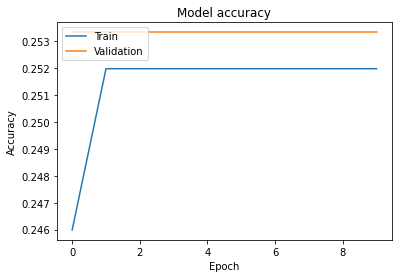

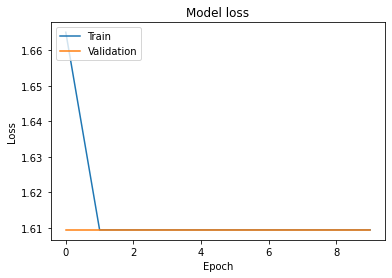

In [56]:
# Plot training and validation accuracy values
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

***Podemos observar que solo aumentar los datos no fue suficiente para mejorar el rendimiento del modelo, La mayor cantidad de datos disminuye el accuracy en test y validacion, donde el modelo se comporta practicamente igual en los dos conjuntos de datos.***

<h2>Regularization through early stopping</h2>
<p>We have consistently seen that our neural network overfits at around the third epoch. Hence, another form of regularization is to end training early if validation loss starts increasing. (This is similar to the validation curves we used when constructing classification models.) Although the network will not have found an optimal function in the training data, the looser function that it has found will likely be more generalizable.</p>
<p>You can do this manually by inspecting the data as we have done above and modifying the <code>epochs</code> argument in <code>fit()</code>, but Keras also allows you to easily do this automatically via an <a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping"><code>EarlyStopping</code> callback</a>.</p>

<h3>Exercise 7:</h3>
<p>Experiment with the <code>EarlyStopping</code> callback and explain the results.</p>

**Answer.**

***Esta tecnica de regularizacion busca detener el modelo justo antes de que empieze a sobreajustar, el número correcto de iteraciones para entrenar el modelo se puede determinar a partir de la región en la que la tasa de error de prueba tiene su valor más bajo.***

In [61]:
# Utilizaremos el modelo con el que hemos obtenido resultados casi que invariables en la reduccion
#de las perdidas para probar EarlyStopping callback.

from tensorflow.keras.callbacks import EarlyStopping

stop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta= 0.5, patience=3) #patience es el nuemro de eopcas sin mejora antes de detener

l1_l2 = tf.keras.regularizers.L1L2( l1 = 0.005, l2 = 0.005)
model7 = Sequential()
model7.add(Embedding(20000, 128, input_length=116))
model7.add(Dropout(0.3))
model7.add(Dense(128, activation='relu',kernel_regularizer='l1_l2'))
model7.add(Dropout(0.2))
model7.add(Dense(128, activation='relu',kernel_regularizer='l1_l2'))
model7.add(Dropout(0.2))
model7.add(GlobalMaxPooling1D())
model7.add(Dense(5, activation='sigmoid'))
model7.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history7 = model7.fit(padded_train_sequences, y_train, validation_split=0.2, epochs=10, callbacks= [stop])

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 14s 5ms/sample - loss: 15.2728 - accuracy: 0.1975 - val_loss: 5.2240 - val_accuracy: 0.2062
Epoch 2/10
3200/3200 [==============================] - 10s 3ms/sample - loss: 2.4226 - accuracy: 0.1978 - val_loss: 1.6540 - val_accuracy: 0.1887
Epoch 3/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6505 - accuracy: 0.2053 - val_loss: 1.6512 - val_accuracy: 0.1887
Epoch 4/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6500 - accuracy: 0.2053 - val_loss: 1.6512 - val_accuracy: 0.1887
Epoch 5/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6498 - accuracy: 0.2053 - val_loss: 1.6513 - val_accuracy: 0.1887
Epoch 6/10
3200/3200 [==============================] - 11s 3ms/sample - loss: 1.6497 - accuracy: 0.2053 - val_loss: 1.6509 - val_accuracy: 0.1887


***El modelo se detuvo despues de 6 epocas cuando despues de tres epocas cosecutivas no se presento una variacion mayor al min_delta definido con parametro en la funcion EarlyStopping***

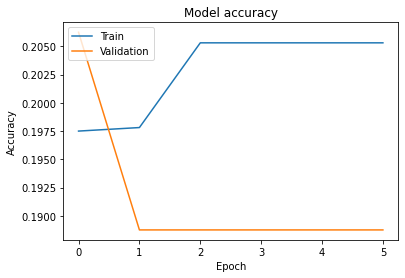

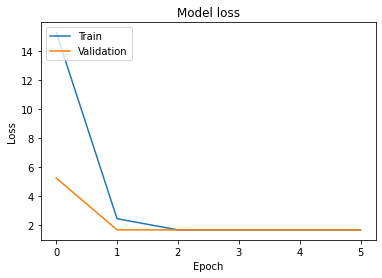

In [62]:
# Plot training and validation accuracy values
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<h2>Evaluating our model</h2>

<p>Unlike in most previous cases, we used <em>three</em> splits of our data instead of two. All of our model tuning has been done on the validation set, and we have not even touched the test set that we split off right at the start.</p>
<p>For experiments, it's very important that your model is only run <strong>once</strong> on your test set. As there is so much randomness at play, it's vital to not "cherry-pick" the best results, so optimize as much as you want on the validation set, but keep the test set until the end and all official results should be based on the single run of the test set (or whatever configuration was decided <em>before the experiment started</em>).</p>

<h3>Exercise 8:</h3>
<p>Let's take the model configuration that resulted in the highest validation accuracy and use that one as our final model. Evaluate this configuration on how well it performs on the test set, and furthermore diagnose <em>what kinds of mistakes it makes</em>. Explain whether these mistakes are expected or not, and print some of these poorly classified reviews. Given the mistakes the model made, how would you then go back and try to improve the model or optimize the tuning steps?</p>
<p><strong>Hint:</strong> You can use the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict_classes"><code>predict_classes</code></a> method on your model to get the most probable class directly.</p>

**Answer.**

In [67]:
#Para evaluar el modelo vamos a usar nuestros datos de test
test_loss, test_acc = model2.evaluate(padded_test_sequences, y_test)
print(f'Las perdidas en el set de test son {test_loss:.2f} el accuracy en test es {test_acc*100:.2f}%')

1000/1000 [==============================] - 2s 2ms/sample - loss: 3.7036 - accuracy: 0.2530
Las perdidas en el set de test son 3.70 el accuracy en test es 25.30%


In [87]:
y_pred = model2.predict(padded_test_sequences)

2

In [88]:
for idx, prediction in enumerate(y_pred):
    print('We predict: '+str(np.argmax(y_pred[idx]))+'. Real Score was: '+str(y_test.iloc[idx]))

We predict: 3. Real Score was: 3
We predict: 2. Real Score was: 1
We predict: 1. Real Score was: 2
We predict: 1. Real Score was: 2
We predict: 1. Real Score was: 1
We predict: 1. Real Score was: 4
We predict: 1. Real Score was: 3
We predict: 0. Real Score was: 3
We predict: 3. Real Score was: 3
We predict: 2. Real Score was: 0
We predict: 4. Real Score was: 0
We predict: 3. Real Score was: 2
We predict: 1. Real Score was: 0
We predict: 1. Real Score was: 3
We predict: 3. Real Score was: 1
We predict: 1. Real Score was: 1
We predict: 0. Real Score was: 2
We predict: 4. Real Score was: 0
We predict: 0. Real Score was: 2
We predict: 3. Real Score was: 0
We predict: 3. Real Score was: 2
We predict: 2. Real Score was: 0
We predict: 1. Real Score was: 0
We predict: 0. Real Score was: 2
We predict: 3. Real Score was: 4
We predict: 3. Real Score was: 2
We predict: 2. Real Score was: 2
We predict: 4. Real Score was: 0
We predict: 0. Real Score was: 4
We predict: 1. Real Score was: 1
We predict

We predict: 2. Real Score was: 1
We predict: 1. Real Score was: 2
We predict: 2. Real Score was: 4
We predict: 4. Real Score was: 4
We predict: 3. Real Score was: 3
We predict: 0. Real Score was: 2
We predict: 4. Real Score was: 3
We predict: 4. Real Score was: 3
We predict: 3. Real Score was: 2
We predict: 1. Real Score was: 4
We predict: 3. Real Score was: 3
We predict: 3. Real Score was: 3
We predict: 0. Real Score was: 4
We predict: 3. Real Score was: 3
We predict: 3. Real Score was: 4
We predict: 3. Real Score was: 2
We predict: 3. Real Score was: 4
We predict: 4. Real Score was: 3
We predict: 0. Real Score was: 1
We predict: 1. Real Score was: 0
We predict: 4. Real Score was: 3
We predict: 3. Real Score was: 1
We predict: 3. Real Score was: 0
We predict: 1. Real Score was: 3
We predict: 2. Real Score was: 0
We predict: 2. Real Score was: 3
We predict: 4. Real Score was: 0
We predict: 4. Real Score was: 4
We predict: 3. Real Score was: 0
We predict: 4. Real Score was: 4
We predict

***En nuestro conjunto de test solo se alcanza un accuracy del 25%, lo que equivale a 50% menos de lo obtenido en el conjunto de validacion***

***En conclusion tratar de afrontar un problema de clasificacion multiclase con texto solo utilizando la caracterizacion de los datos con una simple bolsa de palabras no permite obtener resultados obtimos del clasificador, aun cuando las clases tienen una distribucion uniforme.***

<p>Hopefully, you have seen from this that there is no one-size-fits-all method when creating model architectures or tuning parameters. Often times, copious experimentation is needed, and even then it can be difficult to get significantly better results than a baseline model or even really diagnose what is going wrong under the hood (since neural networks are so "black-box"). In many cases, the quantity and quality of the data itself is far more important than the architecture of the network for getting good results.</p>